In [0]:
!pip install rouge==0.3.1
!pip install tokenizers
!pip install pytorch-lightning
!pip install -U transformers

In [0]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import nltk
import torch
import random
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl

In [0]:
nltk.download('punkt')

In [0]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Three news datasets: 'Газета', 'РИА Новости', 'Свободная пресса'.

"РИА Новости", "Свободная пресса" gives only text and headlines, "Газета" consist of text, summary, headlines.

In [0]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
os.chdir('/content/drive/My Drive/Huawei')

In [0]:
os.getcwd()

In [0]:
def read_gazeta_records(file_name, shuffle = True):
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(eval(line))
    records = pd.DataFrame(records)
    if shuffle:
        records = records.sample(frac=1)
    return records

In [0]:
data_rio = pd.read_csv('data_rio.csv')
data_svbpress = pd.read_csv('data_main.csv')
data_rio = data_rio.drop_duplicates()
data_svbpress.drop("Unnamed: 0", axis='columns', inplace=True)
data_svbpress.columns = ['text', 'title']
data_svbpress['text'] = data_svbpress['text'].apply(lambda x: str(x))
data_rio['text'] = data_rio['text'].apply(lambda x: str(x))

In [0]:
train_gazeta = read_gazeta_records("gazeta_train.txt")
val_gazeta = read_gazeta_records("gazeta_val.txt")
test_gazeta = read_gazeta_records("gazeta_test.txt")
train_gazeta.drop(['url','date'], axis='columns', inplace=True)
val_gazeta.drop(['url','date'], axis='columns', inplace=True)
test_gazeta.drop(['url','date'], axis='columns', inplace=True)

In [0]:
data_svbpress.head()

In [0]:
data_rio.head()

In [0]:
train_gazeta.head()

In [0]:
X_train_svbpress, X_val_svbpress = train_test_split(data_svbpress.iloc[2000:], test_size=0.2)
X_test_svbpress = data_svbpress.iloc[:2000]

In [0]:
X_train_rio, X_val_rio = train_test_split(data_rio.iloc[5000:], test_size=0.2)
X_test_rio = data_rio.iloc[:5000]

Statistics for datasets

In [0]:
print(f'gazeta: train:{len(train_gazeta)}| val:{len(val_gazeta)}| test:{len(test_gazeta)}')
print(f'rio: train:{len(X_train_rio)}| val:{len(X_val_rio)}| test:{len(X_test_rio)}')
print(f'svbpress: train:{len(X_train_svbpress)}| val:{len(X_val_svbpress)}| test:{len(X_test_svbpress)}')

gazeta: train:52400| val:5265| test:5770
rio: train:73963| val:18491| test:5000
svbpress: train:22312| val:5579| test:2000


I will use 2 metrics: BLEU and ROUGE. They more correlate with human evaluation.

In [0]:
from collections import namedtuple

def calc_scores(references, predictions):
    Metrics = namedtuple("Metrics", "BLEU, ROUGE")
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])
    
    Metrics.BLEU = corpus_bleu([[r] for r in references], predictions)
    print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    rouge = Rouge()
    scores = rouge.get_scores(predictions, references, avg=True)
    Metrics.ROUGE = scores
    print("ROUGE: ", scores)
    return Metrics

### Baseline lead rows

In [0]:
def calc_lead_rows_score(data, n=1, lower=True, summary = 'title'):
    references = []
    predictions = []

    for text, summary in data[['text', summary]].values:
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = text if not lower else text.lower()
        sentences = [sentence for sentence in sent_tokenize(text)] 
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)
    
    return calc_scores(references, predictions)

In [0]:
X_test_svbpress

In [47]:
scores_svbpress = calc_lead_rows_score(X_test_svbpress, n=1)

Ref: фсб предотвратила теракты на юге россии
Hyp: сотрудники фсб во взаимодействии с коллегами из мвд пресекли деятельность действовавшей на территории махачкалы и грозного законспирированной ячейки сторонников террористической организации «исламское государство» *.
BLEU:  0.1562924441829961
ROUGE:  {'rouge-1': {'f': 0.20511201241971977, 'p': 0.15161266466652415, 'r': 0.4164164821289826}, 'rouge-2': {'f': 0.0760298004291592, 'p': 0.05572862101967875, 'r': 0.16833497474747466}, 'rouge-l': {'f': 0.14880496841140162, 'p': 0.1393586631944527, 'r': 0.3852106282606283}}


In [46]:
scores_rio = calc_lead_rows_score(X_test_rio, n=1)

Ref: техрегулирование - тема заседания комиссии по модернизации экономики
Hyp:  президент рф дмитрий медведев проведет в липецке первое в этом году заседание комиссии по модернизации экономики, посвященное совершенствованию системы технического регулирования, сообщает пресс-служба кремля.
BLEU:  0.20250873974111167
ROUGE:  {'rouge-1': {'f': 0.23528978247089313, 'p': 0.1629620222229872, 'r': 0.4628657885088771}, 'rouge-2': {'f': 0.10134627488506141, 'p': 0.06891367686074115, 'r': 0.21393361027860888}, 'rouge-l': {'f': 0.16181793878661085, 'p': 0.15046233323360608, 'r': 0.4261026888307769}}


In [33]:
scores_gazeta = calc_lead_rows_score(test_gazeta, n=3, summary = 'summary')

Ref: в ходе спецоперации на территории москвы и республики дагестан силовики задержали четверых участников банды «шараповские» — были изъяты оружие, гранаты и противотанковые комплексы. по данным ск, члены опг причастны к совершению серии убийств предпринимателей и сотрудников правоохранительных органов, а также к похищениям людей, вымогательствам, грабежам и разбоям. кроме того, предполагаемым злоумышленникам вменяют организацию в 1998 году теракта в дагестане.
Hyp: в москве и дагестане следователи ск совместно с сотрудниками фсб и мвд задержали четверых участников организованной преступной группы «шараповские». об этом тасс сообщила старшая помощница руководителя главного следственного управления ск по москве юлия иванова. «с августа по ноябрь на территории республики дагестан и москвы задержаны четыре соучастника преступной группировки», — отметила иванова.
BLEU:  0.43414697189598955
ROUGE:  {'rouge-1': {'f': 0.2631246381422198, 'p': 0.2513271664548712, 'r': 0.29428704269831274}, 'r

## BART model

**Pipeline**:
1. Download and work out with datasets.
2. Train BPE tokenizer 50000 rows will be enough for training.
3. Split dataset and corrupt it.
4. Choose config that is suitable for these datasets.
5. Save model's weights .
6. Train, then generate using greedy/beam search.
7. Repeat experiement few times for more reliable results.

In [0]:
import transformers
from transformers import BartTokenizer
from transformers import BartModel, BartConfig, GPT2Tokenizer, BartForConditionalGeneration, AutoTokenizer, BartTokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.models import BPE
from tokenizers.processors import BertProcessing

In [0]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(["/content/drive/My Drive/Huawei/data_bpe.txt"], vocab_size=30000, special_tokens=["<unk>","<pad>", "<mask>", "<s>", "</s>"])
tokenizer.save('.')

In [0]:
tokenizer = BartTokenizer.from_pretrained('/content/drive/My Drive/Huawei/')

Number of tokens for each dataset

In [0]:
for data in [X_test_rio, X_train_rio, X_val_rio, X_val_svbpress, X_train_svbpress, X_test_svbpress, train_gazeta, val_gazeta, test_gazeta]:
  stat = tokenizer.encode_batch(data['text'].values.tolist())
  len_ = 0
  for i in stat:
    len_ += len(i.ids)
  print(f'num_tokens:{len_}')

num_tokens:1847332
num_tokens:25769188
num_tokens:6438205
num_tokens:1097992
num_tokens:4400700
num_tokens:411171
num_tokens:61405676
num_tokens:6157595
num_tokens:6548405


Out of Vocab rate for each dataset

In [0]:
for data in [X_train_rio, X_val_rio, X_test_rio, X_train_svbpress, X_val_svbpress, X_test_svbpress, train_gazeta, val_gazeta, test_gazeta]:
  stat = tokenizer.encode_batch(data['text'].values.tolist())
  unknown = 0
  len_ = 0
  for i in stat:
    unknown += np.sum(np.array(i.ids) == tokenizer.token_to_id('<unk>'))
    len_ += len(i.ids)
  print(f'out_of_vocab_rate:{unknown/len_*100}')

out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0
out_of_vocab_rate:0.0


In [0]:
from copy import deepcopy


class PretrainingDataset(Dataset):
  def __init__(self,
               data,
               max_seq_length = 300,
               sentence_permutation = True,
               token_masking = False,
               token_deletion = False, 
               text_infilling = True):
    
    self.data = data
    self.pad = 1
    self.mask = 2
    self.sos = 3
    self.eos = 4
    self.max_seq_length = max_seq_length
    self.sentence_permutation = sentence_permutation
    self.token_deletion = token_deletion
    self.token_masking = token_masking
    self.text_infilling = text_infilling

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    x = self.data[idx]
    target = tokenizer.encode_plus(x)['input_ids']

    if self.sentence_permutation:
        split_regex = re.compile(r'[.|!|?|…]')
        sentenced = list(filter(lambda t: t, [t.strip() for t in split_regex.split(x)]))
        x = random.sample(sentenced, len(sentenced))
        x = ' '.join(x)
    x = tokenizer.encode_plus(x)['input_ids'][1:-1]

    if self.token_deletion:
        len_ = len(x)
        idx = random.sample(np.arange(len_).tolist(), int(len_*0.15))
        for i in idx:
          x.remove(x[i])

    if self.token_masking:
        x = np.array(x)
        len_ = len(x)
        idx = random.sample(np.arange(len_).tolist(), int(len_*0.15))
        x[idx] = self.mask
        x = x.tolist()

    if self.text_infilling: 
        x = np.array(x)
        len_ = len(x)
        number_of_spans = random.choice(range(5,8))
        idx = random.sample(np.arange(len_).tolist(), number_of_spans)
        poissons = np.random.poisson(3, number_of_spans)
        new_idx = zip(idx, poissons)
        copy_idx = deepcopy(new_idx)
        x[np.concatenate([np.arange(i, min(i+j+1, len(x))) for i, j in new_idx])] = -1
        x = x.tolist()
        for i, _ in list(copy_idx):
          x.insert(i, self.mask)
        x = np.array(x)
        x = x[x!=-1].tolist()
    
    x = [self.sos] + x + [self.eos]
    attention_mask = [1]*len(x)
    if len(x)>= self.max_seq_length:
      x = x[:self.max_seq_length-1]
      x = x + [self.eos]
      attention_mask = attention_mask[:self.max_seq_length]
    else:
      x += [self.pad]*(self.max_seq_length-len(x))
      attention_mask += [0]*(self.max_seq_length-len(attention_mask))
    
    if len(target)>= self.max_seq_length:
      target = target[:self.max_seq_length-1]
      target = target + [self.eos]
    else:
      target += [self.pad]*(self.max_seq_length-len(target))
    
    x = torch.LongTensor(x)
    attention_mask = torch.LongTensor(attention_mask)
    target = torch.LongTensor(target)
    lm_labels = target[:, 1:].clone()
    lm_labels[target[:, 1:] == 1] = -100

    return {
            'input_ids': x,
            'attention_mask': attention_mask,
            'decoder_input_ids': target,
            'lm_labels': lm_labels
            }

In [0]:
small_pret = pd.read_csv('/content/drive/My Drive/Huawei/data_pret_small.csv')['text'].values
large_pret = pd.read_csv('/content/drive/My Drive/Huawei/data_pret_large.csv')['text'].values

Let's count out of vocab n-gram.

In [0]:
OUV_dataset = PretrainingDataset(large_pret)
OUV_loader = DataLoader(OUV_dataset, batch_size=128)
unknown = 0
for batch in OUV_loader:
  unknown += torch.sum(batch['input_ids'].flatten() == tokenizer.token_to_id('<unk>'))
print(f'Out of vocab:{unknown}')

In [0]:
X_train, X_val = train_test_split(large_pret)
train_dataset = PretrainingDataset(X_train)
val_dataset = PretrainingDataset(X_val)

In [0]:
BATCH_SIZE = 7
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [0]:
BATCH_SIZE = 7
test_dataset = PretrainingDataset(small_pret)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Usually for generation use beam-search and loss with regularization for repeated n-gram

In [0]:
config = BartConfig(vocab_size=tokenizer.vocab_size, 
                    pad_token_id = 1,
                    bos_token_id=3,
                    eos_token_id=4,
                    encoder_layers = 6,
                    decoder_layers = 6
                    )

## Pre-training

In [0]:
from sklearn.metrics import accuracy_score

class BART(LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.hparams = hparams
        self.bart = BartForConditionalGeneration(config)

    def forward(self, decoder_input_ids = None, input_ids=None, attention_mask=None):
        bart_output = self.bart(input_ids=input_ids,
                                attention_mask=attention_mask,
                                decoder_input_ids = decoder_input_ids)
        return bart_output[0]

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=self.hparams.batch_size, shuffle=False)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.7)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, attn, y = batch['input_ids'], batch['attention_mask'], batch['decoder_input_ids']
        loss = self(decoder_input_ids = y[:, :-1], input_ids = x, attention_mask = attn)

        #output_dim = logits.shape[-1]
            
        #output = logits.reshape(-1, output_dim)
        #trg = y[:, 1:].reshape(-1)

        #loss = criterion(output, trg)

        tensorboard_logs = {'train_loss': loss}
        
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, attn, y = batch['input_ids'], batch['attention_mask'], batch['decoder_input_ids']
        loss = self(decoder_input_ids = y[:, :-1], input_ids = x, attention_mask = attn)

        #output_dim = logits.shape[-1]
        #predictions = torch.argmax(logits, dim=-1)

        #ref = tokenizer.batch_decode(y)
        #pred = tokenizer.batch_decode(predictions)
        #bleu = corpus_bleu([[r] for r in ref], pred) 
            
        #output = logits.reshape(-1, output_dim)
        #trg = y[:, 1:].reshape(-1)

        #loss = criterion(output, trg)
        #acc = accuracy_score(torch.argmax(output, dim=-1).cpu(), trg.cpu())
        #acc = torch.tensor(acc)
        #bleu = torch.FloatTensor([bleu])

        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        avg_bleu = torch.stack([x['bleu'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc, 'avg_bleu': avg_bleu}
        return {'val_loss': avg_loss, 'avg_bleu': avg_bleu, 'progress_bar': tensorboard_logs}
    

In [0]:
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from argparse import Namespace
from pytorch_lightning.callbacks import ModelCheckpoint


seed_everything(42)
args = {
    'batch_size': 16,
    'lr': 0.0001 
}
hparams = Namespace(**args)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/Huawei/lightning_logs/pretraining with pad/checkpoints',
    save_top_k=True,
    verbose=True,
    monitor='avg_bleu',
    mode='max',
    prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='avg_bleu',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='max'
)
model = BART(hparams)
trainer = Trainer(gpus=1, max_epochs=15, 
                  early_stop_callback=early_stop_callback, deterministic=True,checkpoint_callback=checkpoint_callback, auto_lr_find=True)
trainer.fit(model)

In [0]:
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

In [0]:
%reload_ext tensorboard
%tensorboard --logdir /lightning_logs

## Fine-tuning

In [0]:
os.chdir('/content')

In [0]:
model = BART.load_from_checkpoint(checkpoint_path="/content/drive/My Drive/Huawei/lightning_logs/pretraining with pad/checkpoints/epoch=10.ckpt")
model_pretrained = model.bart

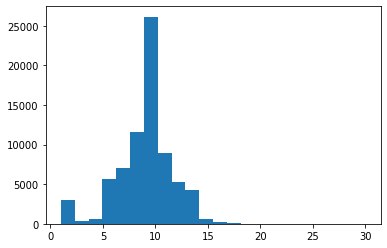

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = X_train_rio['title'].apply(lambda x: len(word_tokenize(x))).values
bins = len(np.unique(x))

fig, ax = plt.subplots()

ax.hist(x, bins)

plt.show()

In [0]:
class FinetuneDataset(Dataset):
  def __init__(self,
               data):
    self.sos = 3
    self.eos = 4
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    x = tokenizer.encode(self.data['text'].values[idx])
    target = tokenizer.encode(self.data['title'].values[idx])
    attention_mask = [1]*len(x)
    
    x = torch.tensor(x)
    attention_mask = torch.tensor(attention_mask)
    target = torch.tensor(target)

    return {'input':x, 'attn':attention_mask, 'target':target}

In [0]:
def collate_fn(records):
  max_len_input = min(300, max(len(record['input']) for record in records))
  max_len_target = max(len(record['target']) for record in records)
  attention_mask = torch.zeros(len(records), max_len_input)
  target = torch.zeros(len(records), max_len_target)
  input = torch.zeros(len(records), max_len_input)

  for i, ten in enumerate(records):
    len_ = min(max_len_input, len(ten['input']))
    input[i, :len_] += ten['input'][:len_]
    input[i][input[i]==0] = 1

    target[i, :len(ten['target'])] += ten['target']
    target[i][target[i]==0] = 1
    
    attention_mask[i, :len_] += ten['attn'][:len_]

  lm_labels = target[:, 1:].clone()
  lm_labels[target[:, 1:] == 1] = -100

  target = target[:, :-1].contiguous()

  return {'input_ids':input.type(torch.LongTensor),
          'attention_mask':attention_mask.type(torch.LongTensor),
          'decoder_input_ids':target.type(torch.LongTensor),
          'lm_labels':lm_labels.type(torch.LongTensor)}

In [0]:
train_dataset = FinetuneDataset(X_train_rio)
val_dataset = FinetuneDataset(X_val_rio)
test_dataset = FinetuneDataset(X_test_rio)

In [0]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, collate_fn=collate_fn)

In [0]:
def loss_calc(logits, labels, smoothing = True):
  labels = labels[:, 1:]
  logits = logits.reshape(-1, logits.size(-1))
  labels = labels.reshape(-1)

  if smoothing:
    eps = 0.1
    num_classes = logits.size(-1)

    log_preds = F.log_softmax(logits, dim=-1)
    loss = -log_preds.sum(dim=-1).mean()
    nll = F.nll_loss(log_preds, labels)
    loss = eps*loss/num_classes + (1-eps)*nll

  else:
    loss = F.cross_entropy(logits, labels)

  return loss

In [0]:
from sklearn.metrics import accuracy_score


class BART_finetune(LightningModule):
    def __init__(self, hparams):
        super(BART_finetune, self).__init__()

        self.hparams = hparams
        self.bart = model_pretrained

    def forward(self, decoder_input_ids = None, input_ids=None, attention_mask=None, lm_labels = None):
        bart_output = self.bart(input_ids=input_ids,
                                attention_mask=attention_mask,
                                decoder_input_ids = decoder_input_ids,
                                lm_labels = lm_labels)
        return bart_output[0]

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size, shuffle=True, collate_fn=collate_fn)
    
    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=self.hparams.batch_size, shuffle=False, collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=self.hparams.batch_size, shuffle=False, collate_fn=collate_fn)

    def configure_optimizers(self):
        optimizer = transformers.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self(**batch)

        tensorboard_logs = {'train_loss': loss}
        
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        loss = self(**batch)

        #output_dim = logits.shape[-1]
        #predictions = torch.argmax(logits, dim=-1)

        #ref = tokenizer.batch_decode(y)
        #pred = tokenizer.batch_decode(predictions)
        #bleu = corpus_bleu([[r] for r in ref], pred) 

        #acc = accuracy_score(torch.argmax(logits.reshape(-1, output_dim), dim=-1).cpu(), y[:, 1:].reshape(-1).cpu())
        #acc = torch.tensor(acc)
        #bleu = torch.FloatTensor([bleu])

        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        #avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        #avg_bleu = torch.stack([x['bleu'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'progress_bar': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        loss = self(**batch)

        #output_dim = logits.shape[-1]
        #predictions = torch.argmax(logits, dim=-1)

        #ref = tokenizer.batch_decode(y)
        #pred = tokenizer.batch_decode(predictions)
        #ref_b = [' '.join([tokenizer.decode(i)]) for i in y]
        #pred_b = [' '.join([tokenizer.decode(i)]) for i in predictions]

        #bleu = corpus_bleu([[r] for r in ref], pred) 

        #rouge = Rouge()
        #rouge = rouge.get_scores(pred_b, ref_b, avg=True, ignore_empty = True)
        #rouge_2_f, rouge_l_f = torch.tensor(rouge['rouge-2']['f']), torch.tensor(rouge['rouge-l']['f'])

        #acc = accuracy_score(torch.argmax(logits.reshape(-1, output_dim), dim=-1).cpu(), y[:, 1:].reshape(-1).cpu())
        #acc = torch.tensor(acc)
        #bleu = torch.FloatTensor([bleu])

        return {'test_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        #avg_val_test = torch.stack([x['test_acc'] for x in outputs]).mean()
        #avg_bleu = torch.stack([x['bleu'] for x in outputs]).mean()
        
        #rouge_2 = torch.stack([x['rouge-2'] for x in outputs]).mean()
        #rouge_l = torch.stack([x['rouge-l'] for x in outputs]).mean()

        tensorboard_logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'progress_bar': tensorboard_logs}

In [0]:
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from argparse import Namespace
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/Huawei/lightning_logs/finetune with pretrain gazeta',
    save_top_k=True,
    verbose=True,
    monitor='avg_bleu',
    mode='max',
    prefix=''
)

seed_everything(42)
args = {
    'batch_size': BATCH_SIZE,
    'lr': 0.0004,
    'num_epoch':10,
}
hparams = Namespace(**args)

model = BART_finetune(hparams)
trainer = Trainer(gpus=1, max_epochs=15,deterministic=True, auto_lr_find=True)
trainer.fit(model)

In [0]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [0]:
trainer.test()

In [0]:
ref = []
pred = []
for i, args in enumerate(test_loader):
  pred.append(tokenizer.decode(model.bart.generate(args['input_ids']).squeeze()))
  ref.append(tokenizer.decode(args['decoder_input_ids'].squeeze()))
calc_scores(ref, pred)

In [0]:
for i, args in enumerate(test_loader):
  print(80*'-')
  print('text:', tokenizer.batch_decode(args['input_ids'])[0])
  print('predicted:', tokenizer.decode(model.bart.generate(args['input_ids']).squeeze()))
  print('reference:', tokenizer.decode(args['decoder_input_ids'].squeeze()))
  if i==10:break

In [0]:
!nvidia-smi

In [0]:
torch.cuda.empty_cache()

## Extractive method

I will try to use extractive method so as to compare with abstractive method.
Extractive methods, obviously, extract sentences from the text, so we need labeled data, but it is tough. In order to get these labels I will use oracle algorithm, which select sentences that are best suited to reference summary.
For this task I will use SummerRunner with pretrained sentence embeddings.




In [0]:
!pip install -U sentence-transformers
!pip install razdel
!pip install catalyst
!pip install rouge

In [0]:
import copy
import random
import razdel

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    gold_summary = gold_summary.lower() if lower else gold_summary
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    score = -1.0
    summaries = []
    for _ in range(min(n_sentences, 2)):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Add sentence to summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Calculate metrics
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # If the mectrics have been updated, add more
        # Else finish
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [0]:
from sentence_transformers import SentenceTransformer, models
word_embedding_model = models.Transformer('DeepPavlov/rubert-base-cased-sentence')

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [0]:
from rouge import Rouge
import razdel
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    sentences_ = []
    oracle_sentences_ = []
    oracle_summary_ = []
    records = records.iloc[:nrows].copy()

    for text, summary in tqdm(records[['text', 'summary']].values):
        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        sentences_ += [sentences]
        oracle_sentences_ += [list(sentences_indicies)]
        oracle_summary_ += [oracle_summary]
    records['sentences'] = sentences_
    records['oracle_sentences'] = oracle_sentences_
    records['oracle_summary'] = oracle_summary_
    return records

ext_train_records = add_oracle_summary_to_records(train_gazeta, nrows=10000)
ext_val_records = add_oracle_summary_to_records(val_gazeta, nrows=1000)
ext_test_records = add_oracle_summary_to_records(test_gazeta, nrows=1000)

In [0]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


from torch.utils import data


class ExtDataset(data.Dataset):
    def __init__(self, records, vocabulary, lower=True,max_sentence_length=50, device=torch.device('cuda')):
        self.records = records
        self.num_samples = records.shape[0]
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.records.shape[0]

    def __getitem__(self, idx):
        cur_record = self.records.iloc[idx]
        outputs = [int(i in cur_record['oracle_sentences']) for i in range(len(cur_record['sentences']))]

        return {'inputs': cur_record['sentences'], 'outputs': outputs}

In [0]:
def collate_fn(records):
    max_sentences = max(len(record['outputs']) for record in records)

    inputs = torch.zeros(len(records), max_sentences, 768)
    outputs = torch.zeros((len(records), max_sentences))
    for i, record in enumerate(records):
      inputs[i, :len(record['inputs'])] += torch.tensor(encoder.encode(record['inputs']))
      outputs[i, :len(record['outputs'])] += np.array(record['outputs'])
            
    return {'inputs': inputs, 'targets': outputs.type(torch.FloatTensor)}

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack


class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super(SentenceEncoderRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        return sentences_embeddings


class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 token_embedding_dim=256,
                 sentence_encoder_hidden_size=768,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=1,
                 dropout=0.3):
        super(SentenceTaggerRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

    def forward(self, inputs, hidden = None):
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        outputs, _ = self.rnn_layer(inputs, hidden)
        outputs = self.dropout_layer(outputs)
        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        content = self.content_linear_layer(outputs).squeeze(2)
        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)
        return content + salience

model = SentenceTaggerRNN()

In [0]:
import catalyst
from catalyst.dl.runner import SupervisedRunner

device = torch.device('cuda')

loaders = {
    'train': data.DataLoader(ExtDataset(ext_train_records, None), batch_size=32, collate_fn=collate_fn),
    'valid': data.DataLoader(ExtDataset(ext_val_records, None), batch_size=32, collate_fn=collate_fn),
    'test': data.DataLoader(ExtDataset(ext_test_records, None), batch_size=32, collate_fn=collate_fn),
}

lr = 1e-3
num_epochs = 2

optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
runner = SupervisedRunner(
    input_key=(
        "inputs"
    )
)
runner.train(
    model=model,
    optimizer=optimizer,
    loaders=loaders,
    logdir='./logs',
    num_epochs=num_epochs,
    criterion=criterion,
    verbose=True
)

In [0]:
from nltk.translate.bleu_score import corpus_bleu
device = torch.device("cuda")

references = []
predictions = []
model.eval()
for i, item in tqdm(enumerate(data.DataLoader(ExtDataset(ext_test_records, None), batch_size=1, collate_fn=collate_fn)), total=ext_test_records.shape[0]):
    logits = model(item["inputs"].to(device))[0] # Прямой проход
    record = ext_test_records.iloc[i]
    predicted_summary = []
    for i, logit in enumerate(logits):
        if logit > 0.15:
            predicted_summary.append(record['sentences'][i])
    if not predicted_summary:
        predicted_summary.append(record['sentences'][torch.max(logits, dim=0)[1].item()])
    predicted_summary = " ".join(predicted_summary)
    references.append(record['summary'].lower())
    predictions.append(predicted_summary)

calc_scores(references, predictions)

100%|██████████| 1000/1000 [01:03<00:00, 15.84it/s]


Ref: в азербайджане 9 февраля прошли внеочередные парламентские выборы. по итогам обработки 87% протоколов победу одерживает правящая партия «ени азербайджан», она может получить до 65 мест из 125. внеочередные выборы прошли в рамках новой кадровой политики президента, призванной ускорить проведение реформ. глава государства в конце прошлого года почти полностью обновил кабмин. серьезные правительственные кадровые изменения становятся тенденцией на постсоветском пространстве.
Hyp: 9 февраля в азербайджане прошли первые в истории страны внеочередные парламентские выборы. правящая партия «ени азербайджан» уже объявила о своей победе.
BLEU:  0.4145022687253822
ROUGE:  {'rouge-1': {'f': 0.24765908811075263, 'p': 0.30595039390157663, 'r': 0.24025562750931886}, 'rouge-2': {'f': 0.10928223237916704, 'p': 0.13632797476823622, 'r': 0.10623049944846108}, 'rouge-l': {'f': 0.2228707656753949, 'p': 0.27253872596430306, 'r': 0.21433428110953515}}


__main__.Metrics